Importing

In [363]:
import torch
from torch.optim import Adam
from torch.optim import LBFGS
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from scipy import integrate # numerical integration tool for ode's

Physical System to Model: Spring, Mass, and Damper System

$ F(t) -c \frac{d\mathbf{x}}{d t}(t) - kx(t) = m\frac{d\mathbf{x^2}}{d t}(t)$

$\frac{d\mathbf{x^2}}{d t}(t) = ( F(t) -c \frac{d\mathbf{x}}{d t}(t) - kx(t) ) /m$

Text(0.5, 1.0, 'Numerical Solution to Spring, Mass, and Damper system')

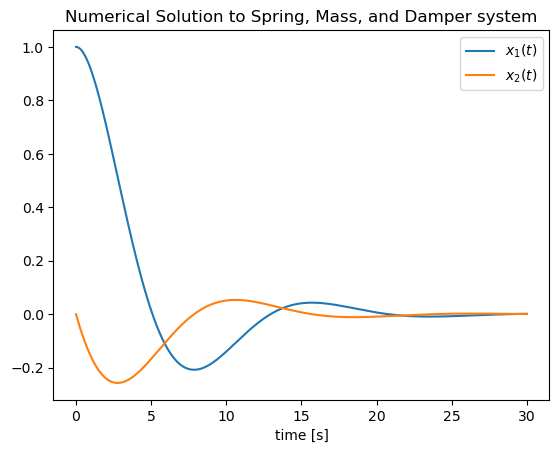

In [364]:
# Physical Parameters, c = damping constant, k =  stiffness of spring, m = mass.
p = dict(c=4, k=2, m=10, F=0, x0=1, dx0dt=0)
p['d2x0dt2'] = (p['F'] - p['c']*p['dx0dt'] - p['k']*p['x0']) / p['m']
#initial conditions
x0 = [p['x0'],p['dx0dt']]
#plot to time T
T = 30

def f(x,t,p):
    x1, x2 = x[0], x[1]
    dx1 = x2
    dx2 = (p['F'] - p['c']*x2 - p['k']*x1) / p['m']
    return([dx1,dx2])

#Function to solve the physical system using numerical integration tool
def run_oscil(x0,T,p):
    t = np.linspace(0, T, 1000)
    dxdt = lambda x,t : f(x, t, p)
    x_t = integrate.odeint(dxdt, x0, t)
    return(t,x_t)

#Plotting neumerical solution
t_plot, x_plot = run_oscil(x0,T,p)
plt.plot(t_plot,x_plot)
plt.xlabel('time [s]')
#x_1 is position, x_2 is velocity
plt.legend(['$x_1(t)$','$x_2(t)$'])
plt.title("Numerical Solution to Spring, Mass, and Damper system")


The equation that models the Spring, Mass, and Damper System is the following:
$ F(t) = m\frac{d\mathbf{x^2}}{d t}(t) + c \frac{d\mathbf{x}}{d t}(t) + kx(t)$

The following parameters are needed to fully define the system:
1. Sum of Forces (F)
2. Mass (m)
3. Damping Constant (c)
4. Spring Stiffness (k)
5. Time (t)
6. Initial Conditions (x0)

These parameters can be used to determine the position (x) at current time (t).

Creating vectors for all parameters to be modelled

In [365]:
train_tuple = tuple()
# Range of t to be modelled [0,30]S
t_train = torch.linspace(0,30,64).view(-1,1)
train_tuple += (t_train,)

#setting other variables as constants
F_train = torch.ones_like(t_train)*p['F']
#train_tuple += (F_train,)
m_train = torch.ones_like(t_train)*p['m']
#train_tuple += (m_train,)
c_train = torch.ones_like(t_train)*p['c']
#train_tuple += (c_train,)
k_train = torch.ones_like(t_train)*p['k']
#train_tuple += (k_train,)
x0_train = torch.ones_like(t_train)*p['x0']
#train_tuple += (x0_train,)
dx0dt_train = torch.ones_like(t_train)*p['dx0dt']
#train_tuple += (dx0dt_train,)
d2x0dt2_train = torch.ones_like(t_train)*p['d2x0dt2']
#train_tuple += (d2x0dt2_train,)

train = torch.cat(train_tuple,1).requires_grad_(True)

Defining the Model, Loss and Optimizer

In [366]:
# i_num nodes, i_len nodes per layer and Tanh activation fn, wide and shallow (64x4)
i_num = 2
i_len = 64
#params to take and approximate
params_in = 1
params_out = 1

# fn to create model
def pinn(input_size, output_size, num_layers, nodes_per_layer, activation):
    layers = []
    
    # Input layer
    layers.append(nn.Linear(input_size, nodes_per_layer))
    
    # Hidden layers
    for _ in range(num_layers):
        layers.append(nn.Linear(nodes_per_layer, nodes_per_layer))
        layers.append(activation(nodes_per_layer))
    
    # Output layer
    layers.append(nn.Linear(nodes_per_layer, output_size))
    
    return nn.Sequential(*layers)

# custom trainable Tanh activation fn
class TTanh(nn.Module):
    def __init__(self, features):
        super().__init__()
        self.features = features
        self.a = nn.Parameter(torch.randn(1, features))
        
    def forward(self, x):
        return torch.tanh(self.a * x)

#custom SIREN activation fn
class Siren(nn.Module):
    def __init__(self, features):
        super(Siren, self).__init__()
        self.features = features
        # Learnable parameters for the phase and bias
        self.phase = nn.Parameter(torch.randn(1, features))
        self.bias = nn.Parameter(torch.randn(1, features))

    def forward(self, x):
        # Apply the periodic activation function
        #x = x.unsqueeze(-1)  # Add a dimension for broadcasting
        x = x + self.phase
        x = torch.sin(x) + self.bias
        return x

model = pinn(params_in, params_out, i_num, i_len, Siren)
# choose optimizer
optim = Adam(model.parameters())    

Creating a custom loss function using the following:

Physics Loss:

$ F(t) - m\frac{d\mathbf{x^2}}{d t}(t) - c \frac{d\mathbf{x}}{d t}(t) - kx(t) = 0$

Initial Conditions Loss:

$x(0) = x_0$

$\frac{d\mathbf{x}}{d t}(0) = \frac{d\mathbf{x_0}}{d t}(t)$

$\frac{d\mathbf{x^2}}{d t}(0) = ( F(t) -c \frac{d\mathbf{x}}{d t}(0) - kx(0) ) /m$

In [367]:
def loss_fn(model, inputs):
    # model: model
    # batch: vector with cols 0:t, 1:F, 2:M, 3:c, 4:k, 5:x(0), 6:x'(0), 7:x''(0)

    # Obtaining parameters to compute loss.
    x_pred = model(inputs)
    first_deriv = torch.autograd.grad(x_pred, inputs, torch.ones_like(x_pred), create_graph=True, retain_graph=True)[0]
    second_deriv = torch.autograd.grad(first_deriv, inputs, torch.ones_like(first_deriv), retain_graph=True)[0]

    dxdt_pred = first_deriv
    d2xdt2_pred = second_deriv

    F = p['F']
    #F = inputs[:,1]
    m = p['m']
    #m = inputs[:,2]
    c = p['c']
    #c = inputs[:,3]
    k = p['k']
    #k = inputs[:,4]

    # Calculate loss based on governing physics eqns
    phy_loss = torch.mean( (F - m*d2xdt2_pred - c*dxdt_pred - k*x_pred)**2 )

    # Calulate loss from boundary conditions
    initial_input = inputs.detach().clone()
    initial_input[:,0] = torch.zeros_like(initial_input[:,0])
    initial_input.requires_grad_(True)
    
    x0_pred = model(initial_input)
    dx0dt_pred = torch.autograd.grad(x0_pred, initial_input, torch.ones_like(x0_pred), create_graph=True, retain_graph=True)[0]
    d2x0dt2_pred = torch.autograd.grad(dx0dt_pred, initial_input, torch.ones_like(dx0dt_pred), retain_graph=True)[0]

    x0 = p['x0']
    #x0 = initial_input[:,5]
    dx0dt = p['dx0dt']
    #dx0dt = initial_input[:,6]
    d2x0dt2 = p['d2x0dt2']
    #d2x0dt2 = initial_input[:,7]

    x0_loss = torch.mean( (x0_pred.view(-1,1) - x0)**2 )
    dx0dt_loss = torch.mean( (dx0dt_pred.view(-1,1) - dx0dt)**2 )
    d2x0dt2_loss = torch.mean( (d2x0dt2_pred.view(-1,1) - d2x0dt2)**2 )
    i_loss = x0_loss + dx0dt_loss + d2x0dt2_loss

    loss = phy_loss + i_loss

    return loss

Comparing plots of MLP approximation against numerical solution.

In [368]:
def plot_comp():
    plt.plot(t_plot,x_plot[:,0],label='Numerical Solution')
    plt.xlabel('time [s]')
    plt.title("Comparing MLP Approximation and Numerical Solution")

    # obtaining plotting information
    # inputs: vector with cols 0:t, 1:F, 2:M, 3:c, 4:k, 5:x(0), 6:x'(0)

    #creating tensors to be plotted
    plot_tuple = tuple()

    plot_t = torch.from_numpy(t_plot).float().view(-1,1)
    plot_tuple += (plot_t,)
    plot_F = torch.ones_like(plot_t)*p['F']
    #plot_tuple += (plot_F,)
    plot_m = torch.ones_like(plot_t)*p['m']
    #plot_tuple += (plot_m,)
    plot_c = torch.ones_like(plot_t)*p['c']
    #plot_tuple += (plot_c,)
    plot_k = torch.ones_like(plot_t)*p['k']
    #plot_tuple += (plot_k,)
    plot_x0 = torch.ones_like(plot_t)*p['x0']
    #plot_tuple += (plot_x0,)
    plot_dx0dt = torch.ones_like(plot_t)*p['dx0dt']
    #plot_tuple += (plot_dx0dt,)
    plot_d2x0dt2 = torch.ones_like(plot_t)*p['d2x0dt2']
    #plot_tuple += (plot_d2x0dt2,)

    plot_input = torch.cat(plot_tuple, 1)
    pred = model(plot_input)
    pred_plot = torch.reshape(pred, (-1,)).detach().numpy()

    plt.plot(t_plot,pred_plot,label='MLP Approximation')
    plt.legend()
    plt.show()
    plt.clf()

Train...

Finished epoch 0, latest loss 5.43E+00
Finished epoch 100, latest loss 5.91E-02
Finished epoch 200, latest loss 4.44E-02
Finished epoch 300, latest loss 5.49E-02
Finished epoch 400, latest loss 3.86E-02
Finished epoch 500, latest loss 3.75E-02
Finished epoch 600, latest loss 3.58E-02
Finished epoch 700, latest loss 2.75E-02
Finished epoch 800, latest loss 2.59E-02
Finished epoch 900, latest loss 3.10E-02
Finished epoch 1000, latest loss 2.46E-02
Finished epoch 1100, latest loss 1.70E-02
Finished epoch 1200, latest loss 2.00E-02
Finished epoch 1300, latest loss 2.94E-02
Finished epoch 1400, latest loss 3.29E-02
Finished epoch 1500, latest loss 1.73E-02
Finished epoch 1600, latest loss 1.20E-02
Finished epoch 1700, latest loss 1.32E-02
Finished epoch 1800, latest loss 2.30E-02
Finished epoch 1900, latest loss 1.43E-02
Finished epoch 2000, latest loss 9.11E-03
Finished epoch 2100, latest loss 8.90E-03
Finished epoch 2200, latest loss 1.04E-02
Finished epoch 2300, latest loss 3.81E-02
Fini

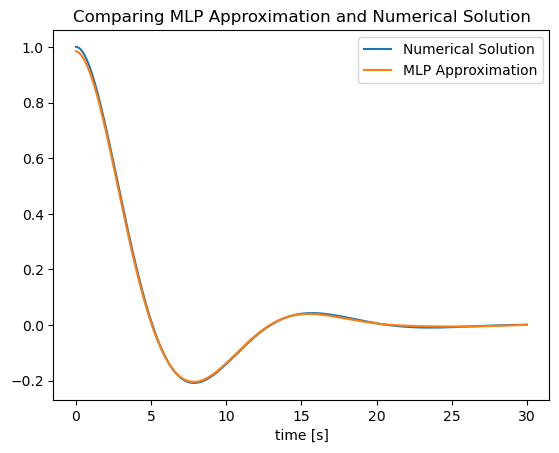

<Figure size 640x480 with 0 Axes>

In [369]:
n_epochs = 5001
prev_loss = list()

def closure():
    loss = loss_fn(model, train)
    optim.zero_grad()
    loss.backward()
    prev_loss.append(loss.item())
    return loss
    
for epoch in range(n_epochs):
    
    loss = loss_fn(model, train)
    optim.zero_grad()
    loss.backward()
    prev_loss.append(loss.item())
    optim.step()
    
    if not (epoch%100):
        print(f'Finished epoch {epoch}, latest loss {prev_loss[-1]:.2E}')

plot_comp()